# **Load Dataset& Import Module**

## **1. Preparation**

#### **Google Drive Mount**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


####  **Dummy File**

In [ ]:
import os, zipfile

dst_path='/gdrive/Shared drives/Cyber_Attack_Detection/'
dst='/content/Dacon_Contest'
dst_file=dst_path+'data.zip'

if not os.path.exists(dst):
    os.makedirs(dst)

with zipfile.ZipFile(dst_file,mode='r') as file:
    file.extractall(dst)

In [ ]:
'''
 have to install TaPR_pkg for Accuracy measurement(etc : recall, f1, accuracy ..) 
'''
!pip install '/content/Dacon_Contest/eTaPR-1.12-py3-none-any.whl'

Processing ./Dacon_Contest/eTaPR-1.12-py3-none-any.whl


#### **Import Module**

In [ ]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

## 2.Preprocessing

In [ ]:
TRAIN_DATASET = sorted([x for x in Path("/content/Dacon_Contest/HAI 2.0/training/").glob("*.csv")])
TRAIN_DATASET

[PosixPath('/content/Dacon_Contest/HAI 2.0/training/train1.csv'),
 PosixPath('/content/Dacon_Contest/HAI 2.0/training/train2.csv'),
 PosixPath('/content/Dacon_Contest/HAI 2.0/training/train3.csv')]

In [ ]:
VALID_DATASET = sorted([x for x in Path("/content/Dacon_Contest/HAI 2.0/validation/").glob("*.csv")])
VALID_DATASET

[PosixPath('/content/Dacon_Contest/HAI 2.0/validation/validation.csv')]

In [ ]:
TEST_DATASET = sorted([x for x in Path("/content/Dacon_Contest/HAI 2.0/testing/").glob("*.csv")])
TEST_DATASET

[PosixPath('/content/Dacon_Contest/HAI 2.0/testing/test1.csv'),
 PosixPath('/content/Dacon_Contest/HAI 2.0/testing/test2.csv'),
 PosixPath('/content/Dacon_Contest/HAI 2.0/testing/test3.csv'),
 PosixPath('/content/Dacon_Contest/HAI 2.0/testing/test4.csv')]

In [ ]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [ ]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,-3.0660,-0.00297,301.01636,40.49072,10,1000.44769,397.63785,4795.0,0,1,16495.0,0,1,4.01474,15454.0,763.19324,246.43968,8.46252,0,1.29784,35.74219,1973.19031,10052.0,10,1,1,100.0,10,1001.99799,37.14706,0,100.0,815.0,20,4.1758,166.74039,11.89504,54074.0,0,780.0,608.0,1,0,-0.00072,100.0,51.58201,2847.02539,0.27786,0.06511,70,2847.02539,540833,712.07275,540833,1,2880,39.09198,0,0.10121,27610.0,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,2020-07-11 00:00:01,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,-2.9721,0.00072,297.43567,40.49072,10,1000.01270,397.63785,4835.0,0,1,16402.0,0,1,3.74347,15461.0,763.19324,246.43968,8.47015,0,1.29692,35.74219,1975.47900,10052.0,10,1,1,100.0,10,1001.99799,37.14477,0,100.0,883.0,20,3.9259,168.64778,11.93421,54089.0,0,781.0,528.0,1,0,-0.00051,100.0,51.60648,2839.58520,0.27634,0.04340,70,2839.58520,540833,708.52661,540833,1,2880,39.05680,0,0.10121,27610.0,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,2020-07-11 00:00:02,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,-2.9857,-0.00145,298.84619,40.49835,10,1000.88245,397.63785,4961.0,0,1,16379.0,0,1,3.43603,15462.0,763.19324,246.05821,8.47015,0,1.29631,35.74219,1972.42725,10050.0,10,1,1,100.0,10,1001.99799,37.14325,0,100.0,956.0,20,3.6489,168.83849,11.97030,54124.0,0,780.0,464.0,1,0,-0.00043,100.0,51.57790,2833.26807,0.27634,0.04340,70,2833.26807,540833,709.15527,540833,1,2880,38.97124,0,0.10121,27617.0,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,2020-07-11 00:00:03,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,-3.2166,-0.00318,297.74310,40.49072,10,1000.88245,397.63785,5022.0,0,1,16422.0,0,1,3.12860,15466.0,763.19324,246.63045,8.46252,0,1.28685,35.74219,1983.10828,10052.0,10,1,1,100.0,10,1001.99799,37.11959,0,100.0,992.0,20,3.3040,170.55510,12.01066,54099.0,0,780.0,416.0,1,0,-0.00072,100.0,51.58236,2834.95264,0.27634,0.02170,70,2834.95264,540833,715.46631,540833,1,2880,38.94103,0,0.10121,27614.0,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,2020-07-11 00:00:04,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,-3.5613,0.00015,297.01965,40.49835,10,1000.01270,397.63785,5088.0,0,1,16355.0,0,1,2.87546,15461.0,763.19324,246.24898,8.47015,0,1.28807,35.74219,1986.16016,10052.0,10,1,1,100.0,10,1001.99799,37.12265,0,100.0,1074.0,20,3.1881,171.31805,11.99684,54094.0,0,782.0,368.0,1,0,-0.00051,100.0,51.62335,2832.70654,0.27710,0.02170,70,2832.70654,540833,709.22852,540833,1,2880,38.90300,0,0.10121,27621.0,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,2020-08-10 10:59:56,387.27219,12,10,66.72057,-0.9331,-1.84479,781.87915,28.02389,880.0,-2.6936,0.00130,359.39307,52.49939,10,1107.37695,386.60074,-22.0,0,1,17069.0,0,1,64.86902,16460.0,763.19324,309.02856,15.00092,0,1.36711,35.34546,1958.69434,10027.0,10,1,1,100.0,10,1109.47327,35.66360,0,100.0,-20.0,20,4.6991,219.95543,11.92414,54121.0,0,782.0,13728.0,1,0,0.00022,100.0,66.63997,2830.03906,0.27557,62.55063,70,2825.96826,540833,716.41846,540833,1,2880,52.09266,0,0.10167,27586.0,944.84705,0.0,1.32843,15.17817,

In [ ]:
TRAIN_DF_RAW.describe()

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
count,921603.000000,921603.0,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.0,921603.000000,921603.000000,921603.000000,921603.0,921603.0,921603.000000,921603.0,921603.0,921603.000000,921603.000000,9.216030e+05,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.0,921603.0,921603.0,921603.000000,921603.0,921603.000000,921603.000000,921603.0,921603.000000,921603.000000,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.0,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.0,921603.000000,921603.0,921603.000000,921603.0,921603.0,921603.0,921603.000000,921603.0,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000,921603.000000
mean,404.114872,12.0,10.0,59.299039,-1.306893,24.950935,783.903738,28.028710,4584.727148,-3.300178,-0.000029,366.128754,68.408152,10.0,1061.042038,403.386064,1150.900176,0.0,1.0,17912.961261,0.0,1.0,33.983808,13354.844493,7.631932e+02,282.638970,11.966074,1.562137,1.391266,36.524979,1132.818153,10050.575157,10.0,1.0,1.0,60.525107,10.0,1061.048787,36.061175,0.0,54.823837,649.357903,20.0,3.981469,194.723654,11.923816,54102.710198,7.810684,783.903917,7133.876717,1.0,0.0,-0.000103,55.000463,58.567863,1778.478447,0.487157,33.994917,70.0,1778.475870,540833.0,711.462809,540833.0,1.0,2880.0,67.465574,0.0,0.093568,27609.032692,879.049682,29.727526,1.377481,12.154333,35.681208,11.842753,332.268971,332.002897,32.316926,6.234405
std,15.631898,0.0,0.0,6.714804,0.349627,40.438485,5.190580,0.003342,5129.999998,0.471033,0.001642,60.615806,23.864600,0.0,61.125489,15.418150,1779.724698,0.0,0.0,1852.143216,0.0,0.0,31.440871,4354.174637,3.804532e-09,33.474213,2.963469,3.630580,0.135774,1.221759,889.196164,17.784770,0.0,0.0,0.0,42.181297,0.0,61.183317,0.671451,0.0,43.299978,1150.921931,0.0,0.499910,27.347982,0.068514,22.455732,18.152900,5.198915,6839.927896,0.0,0.0,0.002032,43.272894,6.599496,1193.345356,0.498712,33.423794,0.0,1193.352273,0.0,8.454726,0.0,0.0,0.0,23.769767,0.0,0.017998,23.917322,75.765703,45.275398,0.061433,2.914615,0.583281,0.096844,34.450944,37.853169,0.578673,0.379803
min,355.988590,12.0,10.0,46.174620,-2.160300,-1.898190,748.933720,28.012540,-8.000000,-4.400900,-0.052440,231.137880,25.537110,10.0,865.699770,369.756010,-27.000000,0.0,1.0,12625.000000,0.0,1.0,0.054230,5047.000000,7.631932e+02,187.149020,0.283810,0.000000,0.947290,34.979250,4.806530,9914.000000,10.0,1.0,1.0,0.000000,10.0,890.078430,34.202320,0.0,0.260930,-24.000000,20.0,2.416200,-15.602130,11.760470,53951.000000,0.000000,749.000000,-288.000000,1.0,0.0,-0.049620,0.000000,45.710510,25.025980,0.170290,-0.007230,70.0,25.025980,540833.0,653.759770,540833.0,1.0,2880.0,24.897280,0.0,0.029780,27530.000000,0.000000,0.000000,0.869140,2.122510,34.689330,11.766050,233.561220,229.872010,31.413430,4.514900
25%,396.626590,12.0,10.0,51.988220,-1.567900,-1.860050,780.357120,28.026450,64.000000,-3.693300,-0.001090,318.051940,44.946290,10.0,1003.990170,396.570710,-20.000000,0.0,1.0,16851.000000,0.0,1.0,0.253200,9826.000000,7.631932e+02,247.802700,8.836360,0.000000,1.313060,35.528560,69.465640,10051.000000,10.0,1.0,1.0,12.154330,10.0,1005.136960,35.606770,0.0,13.589480,-19.000000,20.0,3.567400,174.179030,11.861725,54090.000000,0.000000,780.000000,-192.000000,1.0,0.0,-0.000290,13.990915,51.487450,361.684420,0.274050,-0.007230,70.0,361.684420,540833.0,705.841060,540833.0,1.0,2880.0,44.20

In [ ]:
TIMESTAMP_FIELD = "time"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

NameError: ignored

In [ ]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [ ]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [ ]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()  
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.378953,0.0,0.0,0.227071,0.372380,0.000230,0.386721,0.410567,0.784144,0.508049,0.481272,0.260132,0.200820,0.0,0.478068,0.357101,0.881536,0.0,0.0,0.270592,0.0,0.0,0.045701,0.708779,0.0,0.406877,0.289495,0.0,0.317237,0.139665,0.983325,0.331731,0.0,0.0,0.0,1.0,0.0,0.482697,0.661946,0.0,1.0,0.215404,0.0,0.642237,0.373146,0.444904,0.465909,0.0,0.392405,0.047904,0.0,0.0,0.574348,1.0,0.206193,0.996286,0.049420,0.000870,0.0,0.996286,0.0,0.480318,0.0,0.0,0.0,0.189004,0.0,0.989609,0.808081,0.584892,0.0,0.326835,0.254687,0.331076,0.916661,0.269393,0.265017,1.00000,0.567254
1,0.378504,0.0,0.0,0.226596,0.353516,0.000161,0.399074,0.364415,0.794139,0.540538,0.513907,0.248014,0.200820,0.0,0.476665,0.357101,0.888183,0.0,0.0,0.264680,0.0,0.0,0.042856,0.709212,0.0,0.406877,0.289740,0.0,0.316480,0.139665,0.984365,0.331731,0.0,0.0,0.0,1.0,0.0,0.482697,0.661478,0.0,1.0,0.231276,0.0,0.559318,0.376694,0.562631,0.517562,0.0,0.403913,0.044016,0.0,0.0,0.576590,1.0,0.206974,0.993898,0.048785,0.000633,0.0,0.993898,0.0,0.453764,0.0,0.0,0.0,0.188578,0.0,0.989609,0.808081,0.592044,0.0,0.326835,0.254315,0.337223,0.916661,0.266791,0.251792,1.00000,0.512135
2,0.378463,0.0,0.0,0.226789,0.318663,0.000154,0.393283,0.451729,0.803903,0.538802,0.497829,0.251653,0.200912,0.0,0.479318,0.357101,0.909534,0.0,0.0,0.262699,0.0,0.0,0.039403,0.709313,0.0,0.404518,0.289763,0.0,0.315915,0.139665,0.983085,0.327400,0.0,0.0,0.0,1.0,0.0,0.482697,0.661128,0.0,1.0,0.249590,0.0,0.460764,0.377366,0.680731,0.641653,0.0,0.393545,0.040583,0.0,0.0,0.577639,1.0,0.206140,0.991674,0.048728,0.000612,0.0,0.991674,0.0,0.456037,0.0,0.0,0.0,0.187513,0.0,0.989609,0.871781,0.595523,0.0,0.326387,0.255304,0.337777,0.916661,0.265266,0.254707,1.00000,0.469622
3,0.378904,0.0,0.0,0.226808,0.238782,0.000154,0.393697,0.323289,0.813725,0.459532,0.481088,0.248317,0.200829,0.0,0.479581,0.357101,0.921686,0.0,0.0,0.265209,0.0,0.0,0.035868,0.709568,0.0,0.407820,0.289522,0.0,0.308153,0.139665,0.987761,0.331298,0.0,0.0,0.0,1.0,0.0,0.482697,0.656306,0.0,1.0,0.259723,0.0,0.337699,0.380594,0.812527,0.568703,0.0,0.392519,0.037933,0.0,0.0,0.574677,1.0,0.206199,0.991989,0.048722,0.000374,0.0,0.991989,0.0,0.503051,0.0,0.0,0.0,0.187046,0.0,0.989609,0.850812,0.596151,0.0,0.326343,0.257362,0.331746,0.916661,0.264379,0.253005,1.00000,0.446285
4,0.380282,0.0,0.0,0.226810,0.165794,0.000154,0.412796,0.654203,0.823039,0.333541,0.508572,0.245560,0.200913,0.0,0.476830,0.357101,0.933759,0.0,0.0,0.261243,0.0,0.0,0.032886,0.709287,0.0,0.405793,0.289741,0.0,0.308371,0.139665,0.989600,0.331687,0.0,0.0,0.0,1.0,0.0,0.482697,0.656444,0.0,1.0,0.279682,0.0,0.287332,0.382322,0.784572,0.544370,0.0,0.415201,0.035359,0.0,0.0,0.576601,1.0,0.207500,0.991307,0.049036,0.000351,0.0,0.991307,0.0,0.461506,0.0,0.0,0.0,0.186543,0.0,0.989609,0.912355,0.598763,0.0,0.326786,0.256312,0.337229,0.916661,0.262757,0.247706,1.00000,0.477489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,0.302372,0.0,0.0,0.703684,0.509016,0.000538,0.420902,0.355242,0.064622,0.639006,0.521409,0.479400,0.362090,0.0,0.857718,0.215741,0.000916,0.0,0.0,0.312212,0.0,0.0,0.748503,0.777571,0.0,0.836289,0.520981,0.0,0.379956,0.066785,0.976558,0.271422,0.0,0.0,0.0,1.0,0.0,0.946227,0.328500,0.0,1.0,0.001027,0.0,0.840558,0.482368,0.530142,0.635775,0.0,0.422574,0.749834,0.0,0.0,0.585136,1.0,0.734856,0.990131,0.048367,0.753390,0.0,0.988708,0.0,0.511006,0.0,0.0,0.0,0.362088,0.0,0.995982,0.562762,0.683154,0

In [ ]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [ ]:
boundary_check(TRAIN_DF)

(False, False, False)

In [ ]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

NameError: ignored

In [ ]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=10)
HAI_DATASET_TRAIN[0]


# of valid windows: 92143


{'answer': tensor([3.7600e-01, 0.0000e+00, 0.0000e+00, 2.2681e-01, 3.3856e-01, 1.5367e-04,
         4.5900e-01, 4.2068e-01, 9.8894e-01, 5.2564e-01, 5.2291e-01, 1.6963e-01,
         1.4555e-01, 0.0000e+00, 4.7654e-01, 3.5710e-01, 5.2494e-01, 0.0000e+00,
         0.0000e+00, 1.7465e-01, 0.0000e+00, 0.0000e+00, 6.2612e-19, 8.8022e-01,
         0.0000e+00, 4.0426e-01, 3.2757e-01, 0.0000e+00, 2.2855e-01, 1.3690e-01,
         9.9742e-01, 2.6923e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.8270e-01, 6.0688e-01, 0.0000e+00, 1.0000e+00, 9.1730e-01,
         0.0000e+00, 5.4634e-01, 3.6803e-01, 5.7016e-01, 6.0934e-01, 0.0000e+00,
         4.5543e-01, 8.5543e-04, 0.0000e+00, 0.0000e+00, 5.8175e-01, 1.0000e+00,
         2.1916e-01, 9.9197e-01, 4.9039e-02, 0.0000e+00, 0.0000e+00, 9.9197e-01,
         0.0000e+00, 5.3105e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4237e-01,
         0.0000e+00, 9.8961e-01, 8.6530e-01, 5.8835e-01, 0.0000e+00, 2.9396e-01,
         3.0673e-0

In [ ]:
HAI_DATASET_TRAIN[1]

{'answer': tensor([3.7495e-01, 0.0000e+00, 0.0000e+00, 2.2681e-01, 2.8394e-01, 1.5368e-04,
         4.3736e-01, 3.6840e-01, 9.9305e-01, 2.5189e-01, 4.7465e-01, 3.2644e-01,
         1.4527e-01, 0.0000e+00, 4.7927e-01, 3.5710e-01, 5.1220e-01, 0.0000e+00,
         0.0000e+00, 2.5591e-01, 0.0000e+00, 0.0000e+00, 6.2612e-29, 9.3419e-01,
         0.0000e+00, 4.0299e-01, 3.2757e-01, 0.0000e+00, 2.7340e-01, 1.3966e-01,
         9.7965e-01, 2.6923e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.8270e-01, 6.3473e-01, 0.0000e+00, 1.0000e+00, 9.2462e-01,
         0.0000e+00, 6.9558e-01, 3.6880e-01, 2.2659e-01, 6.7761e-01, 0.0000e+00,
         4.4329e-01, 8.5543e-04, 0.0000e+00, 0.0000e+00, 5.7940e-01, 1.0000e+00,
         2.2106e-01, 9.9049e-01, 4.8053e-02, 0.0000e+00, 0.0000e+00, 9.9049e-01,
         0.0000e+00, 5.0376e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4065e-01,
         0.0000e+00, 9.8961e-01, 7.9044e-01, 5.8605e-01, 0.0000e+00, 2.9475e-01,
         3.1871e-0

In [ ]:
N_HIDDENS = 100
N_LAYERS = 3
BATCH_SIZE = 512


class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.rnn = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=0,
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(outs[-1])
        return x[0] + out
    

In [ ]:
MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
MODEL.cuda()

StackedGRU(
  (rnn): GRU(79, 100, num_layers=5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=79, bias=True)
)

In [ ]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:mse.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

In [ ]:
%%time
MODEL.train()
BEST_MODEL, LOSS_HISTORY = train(HAI_DATASET_TRAIN, MODEL, BATCH_SIZE, 60)

ValueError: ignored

In [ ]:
BEST_MODEL["loss"], BEST_MODEL["epoch"]

In [ ]:
with open("model.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL["state"],
            "best_epoch": BEST_MODEL["epoch"],
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

In [ ]:
with open("model.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])

In [ ]:
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

In [ ]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALID_DATASET)
VALIDATION_DF_RAW

In [ ]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [ ]:
boundary_check(VALIDATION_DF)

In [ ]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]


# of valid windows: 43112


{'answer': tensor([5.2717e-01, 0.0000e+00, 0.0000e+00, 1.6201e-01, 2.4634e-01, 3.0731e-04,
         4.7660e-01, 5.1151e-01, 1.1574e-03, 1.5182e-01, 4.9051e-01, 5.5063e-01,
         2.8699e-01, 0.0000e+00, 4.4413e-01, 4.3588e-01, 2.4863e-02, 0.0000e+00,
         0.0000e+00, 3.4310e-01, 0.0000e+00, 0.0000e+00, 7.5772e-01, 6.8562e-01,
         0.0000e+00, 3.7939e-01, 2.5223e-01, 0.0000e+00, 3.9106e-01, 2.5138e-02,
         9.9257e-01, 3.4135e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.1100e-01, 4.6915e-01, 0.0000e+00, 9.9916e-01, 2.5674e-04,
         0.0000e+00, 5.0073e-01, 3.8212e-01, 2.3146e-01, 6.1364e-01, 0.0000e+00,
         4.8101e-01, 7.6219e-01, 0.0000e+00, 0.0000e+00, 5.8022e-01, 1.0000e+00,
         1.3777e-01, 9.9420e-01, 4.8721e-02, 7.6795e-01, 0.0000e+00, 9.9123e-01,
         0.0000e+00, 4.4749e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8254e-01,
         0.0000e+00, 9.9751e-01, 3.5354e-01, 6.0346e-01, 0.0000e+00, 3.6832e-01,
         2.0053e-0

In [ ]:

def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [ ]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, MODEL, BATCH_SIZE)

In [ ]:
CHECK_DIST.shape

(43112, 79)

In [ ]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [ ]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.5)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

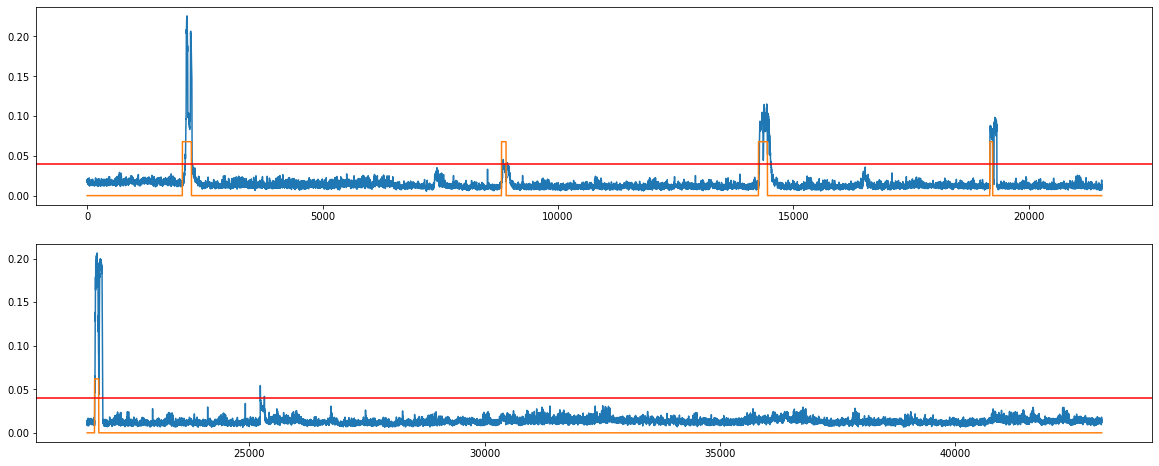

In [ ]:
THRESHOLD = 0.04
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

In [ ]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [ ]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (43112,))

In [ ]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (43201,))

In [ ]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [ ]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

CPU times: user 7.14 s, sys: 6.6 ms, total: 7.14 s
Wall time: 7.14 s


In [ ]:
ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]

True

In [ ]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.906 (TaP: 0.921, TaR: 0.890)
# of detected anomalies: 5
Detected anomalies: ['1', '2', '3', '4', '5']


In [ ]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-09 15:00:00,384.30737,12.0,10,70.35980,-1.6171,-1.79901,774.20752,28.02385,136,-4.0334,-0.00231,284.39673,85.74829,10,1119.12622,382.21698,-29.0,0,1,15844.0,0,1,0.09042,18991.0,763.19324,315.48346,14.52789,0,1.25036,35.48279,1985.39734,10051.0,10,1,1,99.98731,10,1118.61084,35.37903,0,92.51556,-26.0,20,3.9907,220.14613,11.86442,54065.0,0,774.0,-224,1,0,-0.00015,92.69160,69.76647,2835.65454,0.27557,-0.00723,70,2835.65454,540833,697.39990,540833,1,2880,83.46329,0,0.09874,27600.0,936.58447,0.0,1.35437,13.97231,35.22338,12.02545,293.51129,283.92651,32.0,6.5059
1,2020-07-09 15:00:01,384.30737,12.0,10,70.35980,-1.7606,-1.79901,772.58758,28.02730,136,-4.0404,-0.00181,283.47436,85.74829,10,1117.85059,382.21698,-28.0,0,1,15808.0,0,1,0.09042,18991.0,763.19324,315.10199,14.52789,0,1.24944,35.48279,1972.99939,10052.0,10,1,1,100.00000,10,1118.61084,35.37674,0,92.51556,-27.0,20,3.5714,218.23881,11.92675,54073.0,0,773.0,-224,1,0,-0.00015,92.64934,69.74272,2832.98731,0.27634,-0.00723,70,2832.98731,540833,704.41895,540833,1,2880,83.40041,0,0.09874,27600.0,940.93317,0.0,1.35437,13.93358,35.20813,12.02545,292.67938,283.36591,32.0,6.3079
2,2020-07-09 15:00:02,384.20517,12.0,10,70.35980,-1.7606,-1.80664,772.58758,28.02730,136,-4.0404,0.00007,282.69678,85.74829,10,1118.48840,382.21698,-23.0,0,1,15734.0,0,1,0.09042,18991.0,763.19324,316.05570,14.52026,0,1.24746,35.48279,1981.58276,10052.0,10,1,1,99.98115,10,1118.61084,35.37178,0,92.51556,-27.0,20,3.5714,216.90367,11.92675,54073.0,0,773.0,-224,1,0,0.00007,92.91075,69.77000,2842.25244,0.27634,-0.00723,70,2842.25244,540833,704.41895,540833,1,2880,83.34054,0,0.09874,27595.0,936.58447,0.0,1.35513,13.95248,35.20813,12.02545,291.90179,282.93189,32.0,6.3079
3,2020-07-09 15:00:03,384.25626,12.0,10,70.35980,-1.7814,-1.79901,777.48810,28.02905,136,-3.8861,0.00000,283.04034,85.74829,10,1117.85059,382.21698,-29.0,0,1,15710.0,0,1,0.09042,18991.0,763.19324,315.10199,14.51263,0,1.24624,35.48279,1979.86585,10053.0,10,1,1,100.00000,10,1118.61084,35.36873,0,92.51556,-27.0,20,3.3456,221.67204,11.96341,54086.0,0,777.0,-224,1,0,-0.00015,92.92407,69.70607,2833.12744,0.27557,-0.00723,70,2833.12744,540833,704.35791,540833,1,2880,83.26884,0,0.09874,27590.0,933.54034,0.0,1.35513,13.89971,35.20813,12.02545,291.59430,282.06378,32.0,6.1203
4,2020-07-09 15:00:04,384.20517,12.0,10,70.35980,-1.7370,-1.79901,778.42212,28.03169,136,-3.6790,-0.00029,281.99145,85.63384,10,1119.44507,382.21698,-29.0,0,1,15608.0,0,1,0.09042,18992.0,763.19324,315.48346,14.52026,0,1.24364,35.48279,1977.19556,10052.0,10,1,1,100.00000,10,1118.61084,35.36224,0,92.51556,-26.0,20,3.2272,218.23881,11.99236,54086.0,0,778.0,-224,1,0,0.00007,93.05405,69.76971,2839.44482,0.27710,-0.00723,70,2839.44482,540833,700.89111,540833,1,2880,83.18826,0,0.09874,27588.0,944.41223,0.0,1.35437,13.94603,35.20813,12.02545,289.87628,283.67334,32.0,5.9543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,2020-07-31 12:29:56,420.08923,12.0,10,48.31848,-0.8706,97.19238,786.54382,28.03253,232,-3.4769,-0.00231,431.51404,40.38391,10,983.98590,417.58124,-22.0,0,1,19259.0,0,1,71.14441,7140.0,763.19324,240.17335,8.83636,0,1.45290,37.89367,6.14166,10052.0,10,1,1,0.00000,10,989.50207,35.97946,0,3.39661,-20.0,20,3.9836,168.64778,11.87761,54088.0,0,787.0,15248,1,0,-0.00022,3.67038,47.56297,32.97053,0.20462,71.67969,70,31.97761,540833,705.32837,540833,1,2880,40.20410,0,0.06112,27627.0,824.82147,10

In [ ]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.273715,0.0,0.0,0.828325,0.225882,0.000999,0.318761,0.333825,0.010417,0.139867,0.487693,0.198263,0.808607,0.0,0.899123,0.159596,-0.000366,0.0,0.0,0.225073,0.0,0.0,0.000418,0.949670,0.0,0.880684,0.504186,0.0,0.274269,0.092179,0.989424,0.329327,0.0,0.0,0.0,0.999873,0.0,0.985637,0.264512,0.0,0.924960,-0.000513,0.0,0.574677,0.482436,0.343670,0.431818,0.0,0.316456,0.003422,0.0,0.0,0.581043,0.926916,0.844788,0.992272,0.048368,0.000000,0.0,0.992272,0.0,0.359459,0.0,0.0,0.0,0.779812,0.0,0.955389,0.707071,0.677723,0.0,0.317842,0.452044,0.236483,0.944440,0.225971,0.200389,0.26162,0.714722
1,0.273715,0.0,0.0,0.828325,0.171634,0.000999,0.300187,0.426398,0.010417,0.137445,0.492115,0.195142,0.808607,0.0,0.895009,0.159596,-0.000199,0.0,0.0,0.222785,0.0,0.0,0.000418,0.949670,0.0,0.878304,0.504186,0.0,0.273512,0.092179,0.983793,0.331512,0.0,0.0,0.0,0.999988,0.0,0.985637,0.264044,0.0,0.924960,-0.000747,0.0,0.435549,0.478887,0.531007,0.459366,0.0,0.304948,0.003422,0.0,0.0,0.581043,0.926532,0.844029,0.991415,0.048689,0.000000,0.0,0.991415,0.0,0.412018,0.0,0.0,0.0,0.779051,0.0,0.955389,0.707071,0.680584,0.0,0.317842,0.450701,0.230344,0.944440,0.223121,0.198499,0.26162,0.650106
2,0.272825,0.0,0.0,0.828325,0.166747,0.000930,0.298514,0.434738,0.010417,0.137227,0.508991,0.192253,0.808607,0.0,0.896677,0.159596,0.000639,0.0,0.0,0.217918,0.0,0.0,0.000418,0.949670,0.0,0.883986,0.503942,0.0,0.271830,0.092179,0.987149,0.331709,0.0,0.0,0.0,0.999829,0.0,0.985637,0.262997,0.0,0.924960,-0.000768,0.0,0.423015,0.476106,0.547884,0.461848,0.0,0.303912,0.003422,0.0,0.0,0.583371,0.928852,0.844824,0.994285,0.048718,0.000000,0.0,0.994285,0.0,0.416753,0.0,0.0,0.0,0.778264,0.0,0.955389,0.661571,0.678007,0.0,0.318290,0.451229,0.229791,0.944440,0.220223,0.196880,0.26162,0.644285
3,0.273182,0.0,0.0,0.828325,0.158478,0.000992,0.353980,0.482056,0.010417,0.190063,0.510049,0.193118,0.808607,0.0,0.894805,0.159596,-0.000265,0.0,0.0,0.215925,0.0,0.0,0.000418,0.949670,0.0,0.878657,0.503675,0.0,0.270669,0.092179,0.986709,0.333892,0.0,0.0,0.0,0.999983,0.0,0.985637,0.262277,0.0,0.924960,-0.000770,0.0,0.347594,0.484614,0.658648,0.506417,0.0,0.349383,0.003422,0.0,0.0,0.581276,0.929202,0.842882,0.991670,0.048403,0.000000,0.0,0.991670,0.0,0.416770,0.0,0.0,0.0,0.777327,0.0,0.955389,0.611607,0.675769,0.0,0.318335,0.449470,0.229736,0.944440,0.218893,0.193823,0.26162,0.583093
4,0.272773,0.0,0.0,0.828325,0.174269,0.000998,0.370123,0.556914,0.010417,0.266280,0.507615,0.189690,0.807223,0.0,0.899709,0.159596,-0.000356,0.0,0.0,0.209307,0.0,0.0,0.000418,0.949731,0.0,0.880481,0.503892,0.0,0.268436,0.092179,0.985464,0.331947,0.0,0.0,0.0,0.999998,0.0,0.985637,0.260891,0.0,0.924960,-0.000539,0.0,0.301165,0.479140,0.755855,0.510869,0.0,0.365318,0.003422,0.0,0.0,0.583392,0.930407,0.844699,0.993416,0.049004,0.000000,0.0,0.993416,0.0,0.391071,0.0,0.0,0.0,0.776268,0.0,0.955389,0.588433,0.682626,0.0,0.317891,0.450884,0.229731,0.944440,0.212932,0.198888,0.26162,0.523348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,0.619520,0.0,0.0,0.073426,0.532147,0.998079,0.476720,0.581066,0.017489,0.358745,0.489188,0.745671,0.199386,0.0,0.419343,0.612529,0.000896,0.0,0.0,0.463641,0.0,0.0,0.820238,0.142629,0.0,0.362851,0.302727,0.0,0.457515,0.533266,0.000685,0.331426,0.0,0.0,0.0,0.000000,0.0,0.428804,0.399453,0.0,0.031439,0.001027,0.0,0.553210,0.377111,0.414363,0.532206,0.0,0.482937,0.830538,0.0,0.0,0.580477,0.036732,0.065087,0.002776

In [ ]:
boundary_check(TEST_DF)

(True, True, False)

In [ ]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_VALIDATION[0]


# of valid windows: 358448


{'answer': tensor([5.2717e-01, 0.0000e+00, 0.0000e+00, 1.6201e-01, 2.4634e-01, 3.0731e-04,
         4.7660e-01, 5.1151e-01, 1.1574e-03, 1.5182e-01, 4.9051e-01, 5.5063e-01,
         2.8699e-01, 0.0000e+00, 4.4413e-01, 4.3588e-01, 2.4863e-02, 0.0000e+00,
         0.0000e+00, 3.4310e-01, 0.0000e+00, 0.0000e+00, 7.5772e-01, 6.8562e-01,
         0.0000e+00, 3.7939e-01, 2.5223e-01, 0.0000e+00, 3.9106e-01, 2.5138e-02,
         9.9257e-01, 3.4135e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.1100e-01, 4.6915e-01, 0.0000e+00, 9.9916e-01, 2.5674e-04,
         0.0000e+00, 5.0073e-01, 3.8212e-01, 2.3146e-01, 6.1364e-01, 0.0000e+00,
         4.8101e-01, 7.6219e-01, 0.0000e+00, 0.0000e+00, 5.8022e-01, 1.0000e+00,
         1.3777e-01, 9.9420e-01, 4.8721e-02, 7.6795e-01, 0.0000e+00, 9.9123e-01,
         0.0000e+00, 4.4749e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8254e-01,
         0.0000e+00, 9.9751e-01, 3.5354e-01, 6.0346e-01, 0.0000e+00, 3.6832e-01,
         2.0053e-0

In [ ]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, BATCH_SIZE)

CPU times: user 21.2 s, sys: 1.77 s, total: 23 s
Wall time: 23 s


In [ ]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [ ]:
ANOMALY_SCORE

array([0.01003165, 0.00961139, 0.00857315, ..., 0.00799328, 0.00823061,
       0.00661482], dtype=float32)

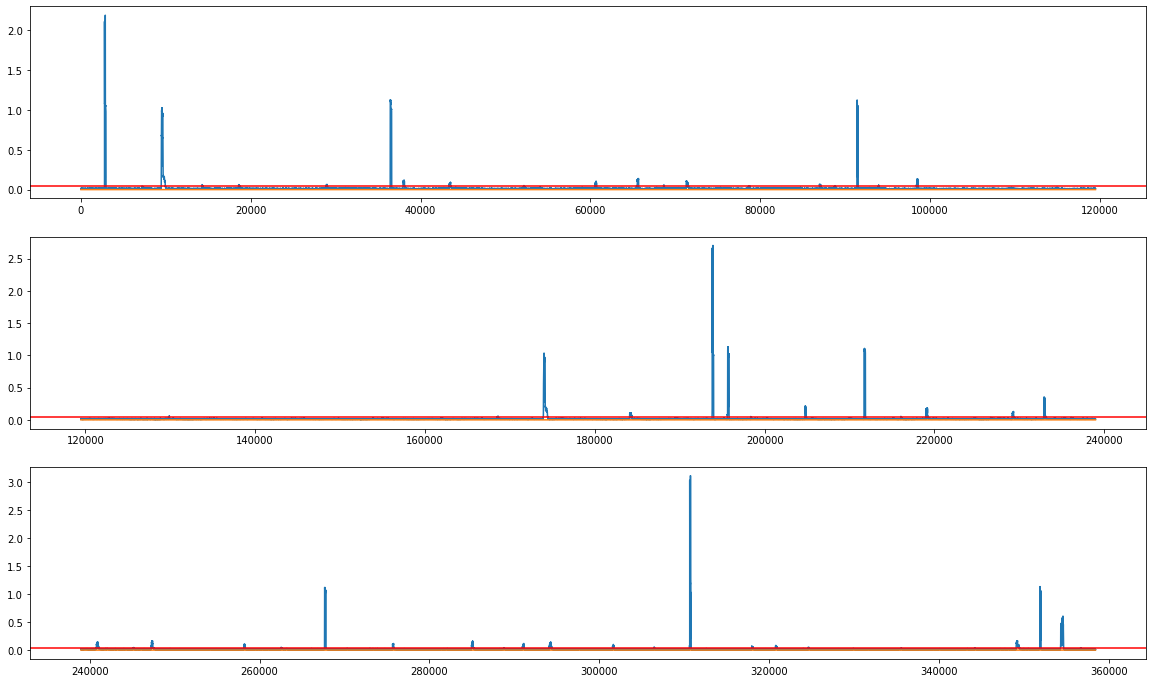

In [ ]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

In [ ]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (358448,))

In [ ]:
submission = pd.read_csv('/content/Dacon_Contest/HAI 2.0/sample_submission.csv')
submission.index = submission['time']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,time,attack
time,,
2020-07-09 15:00:00,2020-07-09 15:00:00,0.0
2020-07-09 15:00:01,2020-07-09 15:00:01,0.0
2020-07-09 15:00:02,2020-07-09 15:00:02,0.0
2020-07-09 15:00:03,2020-07-09 15:00:03,0.0
2020-07-09 15:00:04,2020-07-09 15:00:04,0.0
...,...,...
2020-07-31 12:29:56,2020-07-31 12:29:56,0.0
2020-07-31 12:29:57,2020-07-31 12:29:57,0.0
2020-07-31 12:29:58,2020-07-31 12:29:58,0.0


In [ ]:
submission.to_csv('baseline.csv', index=False)